# Model 16: Bayesian iterated learning

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model16.html

### Note

- Model 16 uses the statistical tools of Bayesian inference to explore how cognitive representations or linguistic features evolve over time as they are passed from person to person, generation to generation.
    - Model 16 concerns the emergence of regularisation in language evolution.
- Bayesian inference is a statistical approach to the problem of how to update one’s beliefs in light of new data.
    - Bayesian inference is useful because it is probabilistic rather than all-or-nothing.
        - We do not seek to accept or reject hypotheses, rather we seek a probability distribution across all possible hypotheses to estimate our (un)certainty in each one.
- Iterated learning is the name to describe the repeated transmission of information from individual to individual along a linear chain of learners.
    - This is much like the 'transmission chains' discussed previously that have been used to study transmission biases in the lab.
    - However, 'iterated learning' is usually placed within a Bayesian framework.
    - The data $d$ comes not from the physical world, nor one’s own body, but from other individuals.
    - Specifically, each individual in the chain generates some data $d$ which is observed by the next individual in the chain.
    - Each learner combines their priors with the likelihood (尤度) of the culturally-transmitted data using Bayes' rule, to generate a posterior distribution across all potential hypotheses.
    - This posterior is used to generate new data which is passed to the next individual in the chain, and so on along the chain.
- Linguists have used iterated learning to study language evolution.
    - Here the data are utterances that contain information about vocabulary or grammatical rules.
    - Subsequent language learners, such as infants learning their first language or adults learning a second language, must infer the grammatical rules of the language from the limited data they receive from other speakers.
    - The priors in this context are innate, cognitively attractive or culturally acquired expectations about the possible hypothesis space of real languages.
- Cognitive scientists have used Bayesian iterated learning to study culturally transmitted representations, such as object categorisation schemes or colour terminologies.
- The question addressed by all this research, as well as Model 16, is: how do languages or cognitive representations culturally evolve over time under the assumption of Bayesian iterated learning?
- One major claim that we will examine in these models is that languages and cognitive structures always come to reflect the priors (or 'inductive biases') of the learners, irrespective of the initial data observed by the first individual in the chain.

## Model 16

- Model 16 recreates a common model of Bayesian iterated learning examining the emergence of linguistic regularisation.
- Imagine a feature that can take one of two forms.
    - Verbs can either follow the subject (“I go”) or precede the subject (“go I”).
    - Social conventions such as shaking hands with either the right or the left hand.
- We define $\theta$ as the probability of one variant (say, subject-verb) being used in the language, and $1−\theta$ as the probability of the other variant (verb-subject) being used.
- Your task as a naive learner is to infer from a set of utterances the grammatical rule used in your society, i.e. to infer the value of $\theta$ for this language, which is unknown to you except via data received from other speakers.
- In particular, we are interested in whether the language is regular or irregular.
    - A regular language always uses the same variant ($\theta = 0$ or $\theta = 1$).
    - An irregular language uses some mix of variants ($0 < \theta < 1$).

In [1]:
using JupyterFormatter
enable_autoformat()

using Distributions
using LaTeXStrings
using Plots
using StatsBase

println("Julia version: ", VERSION)

Julia version: 1.8.5


### 1. Binomial Distribution (二項分布)

In [2]:
# hypothesis space
p = collect(0:0.01:1)

# The data take the form of n independent observations of the grammatical rule.
# In the context of an iterated learning chain, this is like hearing n examples of the grammatical rule from the previous individual in the chain.
n = 10

# We assume that k of these observations fit variant 1 (e.g. subject-verb) while n − k fit variant 2 (e.g. verb-subject).
k = 5

# pdf.(Binomial.(n, p), k) は、成功確率が p である n 回の独立した試行で、k 回の成功を観測する確率の配列を返します。
likelihood = pdf.(Binomial.(n, p), k);

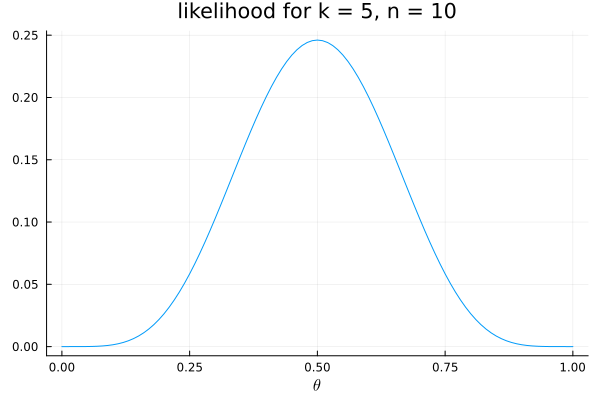

In [3]:
plot(
    p,
    likelihood,
    title = "likelihood for k = $k, n = $n",
    xlabel = L"\theta",
    legend = false,
)

### 2. Generate posteriorgenerate posterior using beta distribution (ベータ分布)

- 事前分布を一様分布とし，尤度が二項分布 (コイン投げ) であるときの事後分布がベータ分布になります。(https://manabitimes.jp/math/1267)

In [4]:
# pの各値におけるベータ分布の確率密度関数の値を返す.
beta_distribution(α::Float64, β::Float64, p::Vector{Float64})::Vector{Float64} =
    pdf.(Beta(α, β), p)

# x軸ラベルが θ のグラフを返す.
plot_by_θ(x::Vector{Float64}, y::Vector{Float64}, title::String)::Plots.Plot =
    plot(x, y, title = title, xlab = L"\theta", legend = false);

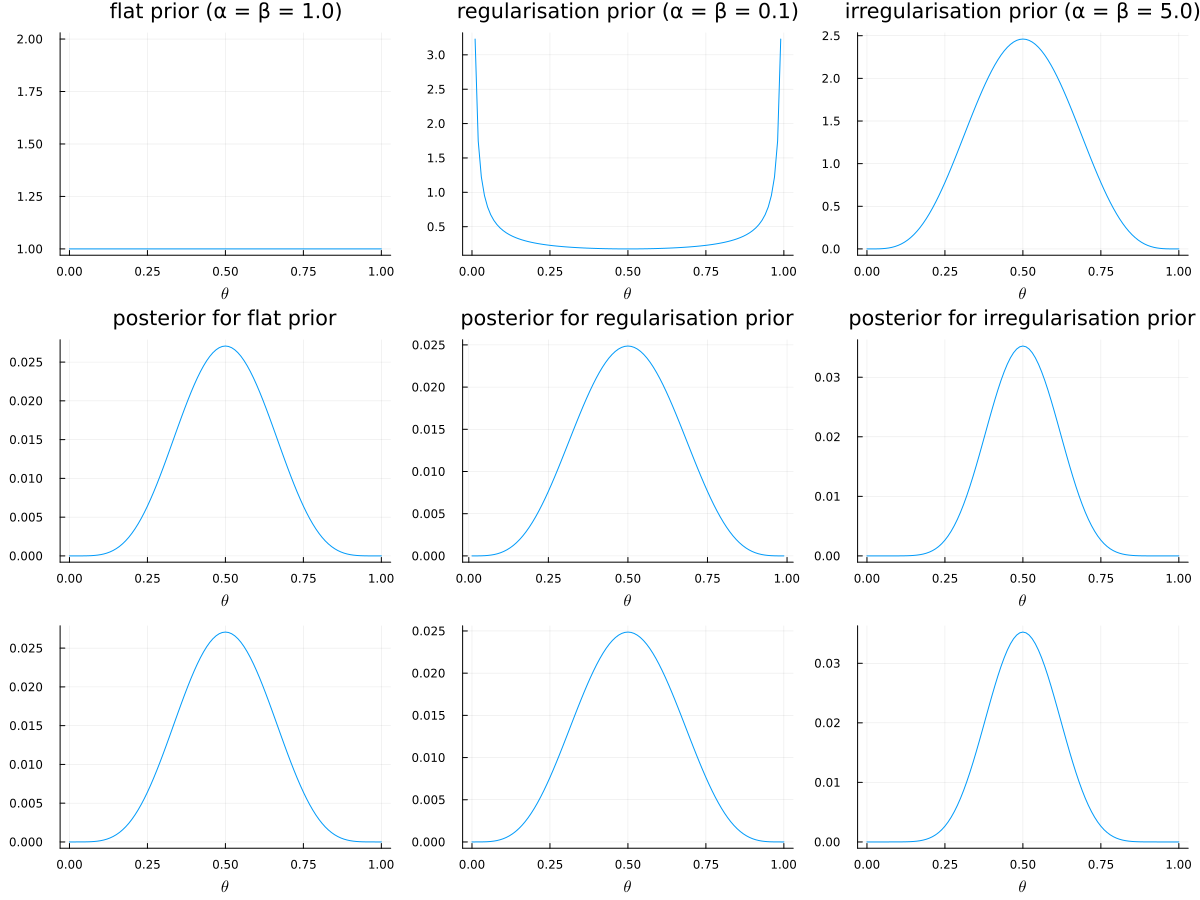

In [5]:
α = β = 1.0
flat_prior = beta_distribution(α, β, p)
prior1 = plot_by_θ(p, flat_prior, "flat prior (α = β = $α)")

α = β = 0.1
regularisation_prior = beta_distribution(α, β, p)
prior2 = plot_by_θ(p, regularisation_prior, "regularisation prior (α = β = $α)")

α = β = 5.0
irregularisation_prior = beta_distribution(α, β, p)
prior3 = plot_by_θ(p, irregularisation_prior, "irregularisation prior (α = β = $α)")

# The posterior distribution is then obtained by multiplying the likelihood by the prior
# and dividing by the sum of all posterior probabilities, as per Bayes’ rule.
posterior = likelihood .* flat_prior
posterior = posterior ./ sum(posterior)
posterior1 = plot_by_θ(p, posterior, "posterior for flat prior")

posterior = filter(!isnan, likelihood .* regularisation_prior)
posterior = posterior ./ sum(posterior)
posterior2 = plot_by_θ(p[2:end-1], posterior, "posterior for regularisation prior")

posterior = likelihood .* irregularisation_prior
posterior = posterior ./ sum(posterior)
posterior3 = plot_by_θ(p, posterior, "posterior for irregularisation prior")

# Simple version
# The key thing is that we can use this fact to generate the posterior direct from k, α and β,
# without having to calculate the prior and likelihood and multiply them together.
function posterior_distribution(
    α::Float64,
    β::Float64,
    p::Vector{Float64},
    n::Int,
    k::Int,
)::Vector{Float64}
    beta = pdf.(Beta(k + α, n - k + β), p)
    beta ./ sum(beta)
end

plot(
    prior1,
    prior2,
    prior3,
    posterior1,
    posterior2,
    posterior3,
    plot_by_θ(p, posterior_distribution(1.0, 1.0, p, n, k), ""),
    plot_by_θ(p, posterior_distribution(0.1, 0.1, p, n, k), ""),
    plot_by_θ(p, posterior_distribution(5.0, 5.0, p, n, k), ""),
    layout = (3, 3),
    size = (1200, 900),
)

### 3. Pick a value of $\theta$ from the posterior distribution

- This will be the hypothesis used to generate the data.
- There are two ways of doing this.
- The first is to randomly sample from the hypothesis space in proportion to the posterior probabilities.
    - This is known as ‘sampling’.
    - Now that we know the conjugate shortcut to calculating the posterior, this can be done with a single rbeta command:
- The second way of choosing a $\theta$ is to pick the hypothesis with the maximum posterior probability.
    - This is known as the 'maximum a posteriori' (MAP, 最大事後確率) hypothesis.
    - To obtain this we can use [the formulae](https://w.wiki/6eRf) for the mode of a beta distribution:

In [6]:
function pick_θ(α::Float64, β::Float64, n::Int, k::Int, sampling::Bool)::Float64
    if sampling
        first(rand(Beta(k + α, n - k + β), 1))
    else
        if (k + α) > 1 && (n - k + β) > 1
            (k + α - 1) / (n + α + β - 2)
        elseif (k + α) <= 1 && (n - k + β) > 1
            0.0
        elseif (k + α) > 1 && (n - k + β) <= 1
            1.0
        else
            throw(DomainError("Something wrong."))
        end
    end
end;

In [7]:
n = 10
k = 5
α = β = 1.0
@show θ = pick_θ(α, β, n, k, true)
@show θ = pick_θ(α, β, n, k, false)

θ = pick_θ(α, β, n, k, true) = 0.6580669556308381
θ = pick_θ(α, β, n, k, false) = 0.5


0.5

### 4. Generate a new $k$

- Now we need to use our $\theta$ to generate a new $k$ to be the data for the next individual in the chain.
- This is another task for the binomial distribution, which converts probabilities into discrete picks.
- The following code uses rbinom to pick a random draw from a binomial with $n$ trials and probability of success $\theta$:

In [8]:
n = 10
k = first(rand(Binomial(n, θ), 1))

6

### 5. Get probability distribution of new picks

- Finally we can generate a probability distribution for all possible values of $k$ across all values of $\theta$ (`prob_k`).
- You can think of this as the posterior transformed from a continuous probability from $0$ to $1$ into a discrete integer scale from $0$ to $n$ to give the probability of each new $k$, without the stochasticity introduced by random picks.
- The following code cycles through all integers from $0$ to $n$ and, for each one, multiplies the posterior across all $p$ values by the binomial distribution for that integer (like we did above with the likelihood).
- We then sum across all $p$ values and normalise to ensure `prob_k` sums to 1.

In [9]:
# hypothesis space
p = collect(0:0.01:1)
n = 10
k = 5
α = β = 5.0

posterior = posterior_distribution(α, β, p, n, k)

prob_k = [sum(pdf.(Binomial.(n, p), j) .* posterior) for j = 0:n]
prob_k = prob_k ./ sum(prob_k)

11-element Vector{Float64}:
 0.004611979724423433
 0.024273577496965806
 0.06675233811665587
 0.12565145998429378
 0.17866066966516742
 0.20009995002498748
 0.17866066966516742
 0.12565145998429375
 0.0667523381166559
 0.02427357749696581
 0.004611979724423432

### 6. Run all

In [115]:
function bayesian_inference(
    n::Int,
    k::Int,
    α::Float64,
    β::Float64,
    sampling::Bool,
)::Tuple{Int,Vector{Float64}}
    # hypothesis space
    p = collect(0:0.01:1)

    # avoid infinity when beta distribution parameters are less than 1
    (k + α) < 1 && (p[1] = 0.00001)
    (n - k + β) < 1 && (p[end] = 0.99999)

    # 2. generate posterior
    posterior = posterior_distribution(α, β, p, n, k)

    # 3. pick a value of θ from the posterior distribution
    θ = pick_θ(α, β, n, k, sampling)

    # 4. draw a new k from a binomial using theta
    k = first(rand(Binomial(n, θ), 1))

    # 5. Get probability distribution of new picks
    prob_k = [sum(pdf.(Binomial.(n, p), j) .* posterior) for j = 0:n]
    prob_k = prob_k ./ sum(prob_k)

    k, prob_k
end

function iterated_learning(;
    n::Int = 10,            # independent observations
    k::Int = 5,
    α::Float64 = 1.0,
    β::Float64 = α,
    sampling::Bool = true,
    generations::Int = 20,  # generations
    trials::Int = 10000,    # trial count
)::Tuple{Vector{Float64},Matrix{Float64},Dict}
    k_vector = fill(0.0, generations)
    k_matrix = fill(0.0, generations, n + 1)

    for trial = 1:trials
        _k = k

        for generation = 1:generations
            _k, _prob_k = bayesian_inference(n, _k, α, β, sampling)
            k_vector[generation] += _k
            k_matrix[generation, :] .+= _prob_k
        end
    end

    k_vector ./= trials
    k_matrix ./= trials
    parameters = Dict(
        :n => n,
        :k => k,
        :α => α,
        :β => β,
        :sampling => sampling,
        :generations => generations,
        :trials => trials,
    )

    return k_vector, k_matrix, parameters
end

function iterated_heat_plot(k_matrix::Matrix{Float64})::Plots.Plot
    generations, n = size(k_matrix)
    heatmap(
        k_matrix,
        yflip = true,
        xticks = (1:n+1, 0:n),  # タプルの第一要素がtickの位置で、第2要素がラベル
        yticks = (1:generations),
        ylabel = "generation",
        xlabel = "k",
        colorbar = false,
    )
end

function iterated_final_plot(
    k_matrix::Matrix{Float64},
    parameters::Dict,
    ymax::Float64 = 0.6,
)::Plots.Plot
    # retrieve parameters
    n = parameters[:n]
    trials = parameters[:trials]
    α = parameters[:α]
    β = parameters[:β]
    k_matrix = k_matrix

    # simulate prior distribution
    prior = fill(0, trials)
    for trial = 1:trials
        θ = first(rand(Beta(α, β), 1))
        prior[trial] = first(rand(Binomial(n, θ), 1))
    end
    prior = counts(prior, 0:n)
    prior /= sum(prior)

    # draw barplot for simulated priors
    names = 0:(length(prior)-1)
    barplot = bar(
        names,
        prior,
        xlabel = "k",
        ylabel = "probability",
        ylims = (0, ymax),
        label = "prior",
    )
    plot!(
        names,
        k_matrix[end, :],
        markerstrokecolor = :black,
        markercolor = :black,
        linecolor = :black,
        markershape = :circle,
        label = "final generation",
    )

end;

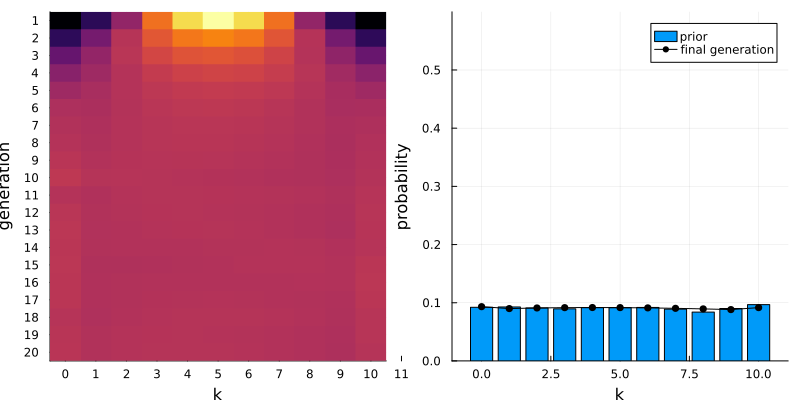

In [94]:
k_vector, k_matrix, parameters = iterated_learning()
plot(
    iterated_heat_plot(k_matrix),
    iterated_final_plot(k_matrix, parameters),
    size = (800, 400),
)

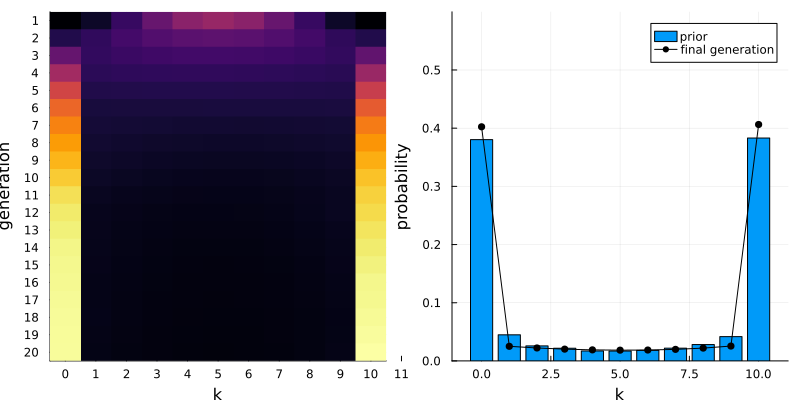

In [95]:
k_vector, k_matrix, parameters = iterated_learning(α = 0.1)
plot(
    iterated_heat_plot(k_matrix),
    iterated_final_plot(k_matrix, parameters),
    size = (800, 400),
)

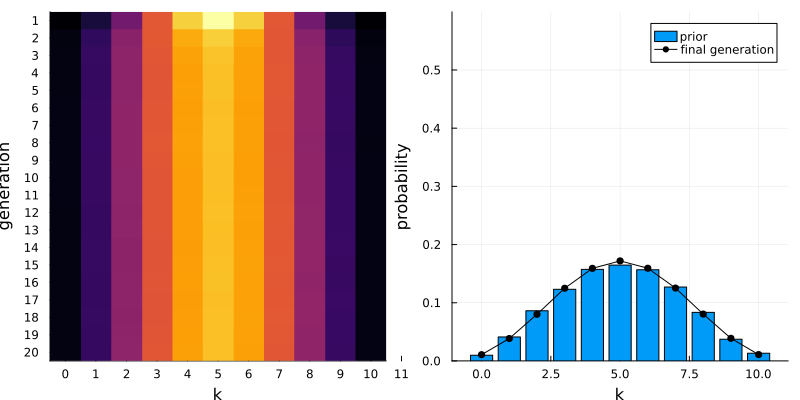

In [96]:
k_vector, k_matrix, parameters = iterated_learning(α = 5.0)
plot(
    iterated_heat_plot(k_matrix),
    iterated_final_plot(k_matrix, parameters),
    size = (800, 400),
)

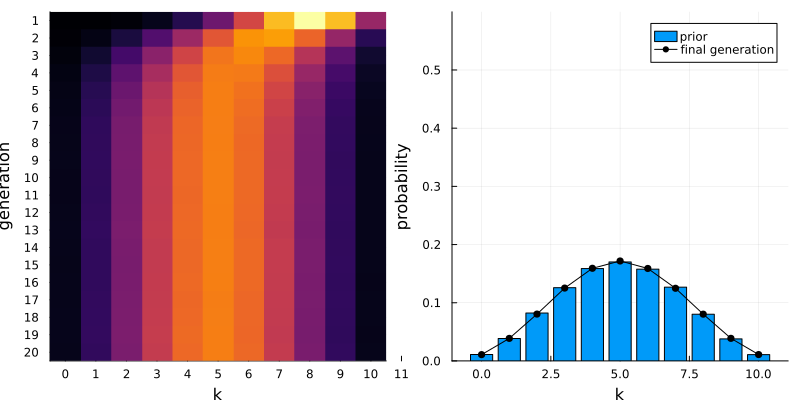

In [97]:
k_vector, k_matrix, parameters = iterated_learning(k = 10, α = 5.0)
plot(
    iterated_heat_plot(k_matrix),
    iterated_final_plot(k_matrix, parameters),
    size = (800, 400),
)

## Two different prior distributions

Navarro et al. (2018) therefore assumed two different prior distributions, i.e. two sets of prior parameters. Each agent in the iterated learning chain uses parameters $\alpha_1$ and $\beta_1$ with probability $h$, and uses $\alpha_2$ and $\beta_2$ with probability $1−h$.



In [123]:
function mixed_iterated_learning(;
    n::Int = 10,            # independent observations
    k::Int = 5,
    α₁::Float64 = 1.0,
    β₁::Float64 = α₁,
    α₂::Float64 = α₁,
    β₂::Float64 = α₁,
    h::Float64 = 0.5,
    sampling::Bool = true,
    generations::Int = 20,  # generations
    trials::Int = 10000,    # trial count
)::Tuple{Vector{Float64},Matrix{Float64},Dict}
    k_vector = fill(0.0, generations)
    k_matrix = fill(0.0, generations, n + 1)

    for trial = 1:trials
        _k = k
        h_prob = rand(generations)  # probability to compare with h

        for generation = 1:generations
            α, β = h_prob[generation] < h ? (α₁, β₁) : (α₂, β₂)
            _k, _prob_k = bayesian_inference(n, _k, α, β, sampling)
            k_vector[generation] += _k
            k_matrix[generation, :] .+= _prob_k
        end
    end

    k_vector ./= trials
    k_matrix ./= trials
    parameters = Dict(
        :n => n,
        :k => k,
        :α₁ => α₁,
        :β₁ => β₁,
        :α₂ => α₂,
        :β₂ => β₂,
        :h => h,
        :sampling => sampling,
        :generations => generations,
        :trials => trials,
    )

    return k_vector, k_matrix, parameters
end

function iterated_final_plot(
    k_matrix::Matrix{Float64},
    parameters::Dict,
    ymax::Float64 = 0.6,
)::Plots.Plot
    # retrieve parameters
    n = parameters[:n]
    trials = parameters[:trials]
    α₁ = parameters[:α₁]
    β₁ = parameters[:β₁]
    α₂ = parameters[:α₂]
    β₂ = parameters[:β₂]
    h = parameters[:h]
    k_matrix = k_matrix

    # simulate prior distribution
    prior = fill(0, trials)
    h_prob = rand(trials)  # probability to compare with h
    for trial = 1:trials
        α, β = h_prob[trial] < h ? (α₁, β₁) : (α₂, β₂)
        θ = first(rand(Beta(α, β), 1))
        prior[trial] = first(rand(Binomial(n, θ), 1))
    end
    prior = counts(prior, 0:n)
    prior /= sum(prior)

    # draw barplot for simulated priors
    names = 0:(length(prior)-1)
    barplot = bar(
        names,
        prior,
        xlabel = "k",
        ylabel = "probability",
        ylims = (0, ymax),
        label = "prior",
    )
    plot!(
        names,
        k_matrix[end, :],
        markerstrokecolor = :black,
        markercolor = :black,
        linecolor = :black,
        markershape = :circle,
        label = "final generation",
    )

end;

In [125]:
_, k_matrix1, parameters1 = mixed_iterated_learning(α₁ = 2.0, β₁ = 1.0)
_, k_matrix2, parameters2 = mixed_iterated_learning(α₁ = 1.0, β₁ = 10.0)
_, k_matrix3, parameters3 = mixed_iterated_learning(α₁ = 2.0, β₁ = 1.0, α₂ = 1.0, β₂ = 10.0)

([4.1217, 3.5972, 3.2377, 2.9839, 2.8901, 2.8507, 2.8048, 2.7614, 2.7621, 2.7749, 2.7512, 2.724, 2.7235, 2.6691, 2.6656, 2.6458, 2.6559, 2.6768, 2.6448, 2.6504], [0.03467563029528631 0.09176732761131022 … 0.0239331329699169 0.006299660035356355; 0.10214457781834699 0.14035992161321081 … 0.028641790368641153 0.01548895466121831; … ; 0.20564351422612798 0.188536168261593 … 0.0147360959202917 0.008956081431091105; 0.21089001268843457 0.18982495810030017 … 0.01517912706167996 0.008964818829190209], Dict{Symbol, Real}(:sampling => true, :trials => 10000, :n => 10, :k => 5, :α₂ => 1.0, :β₁ => 1.0, :β₂ => 10.0, :h => 0.5, :generations => 20, :α₁ => 2.0…))

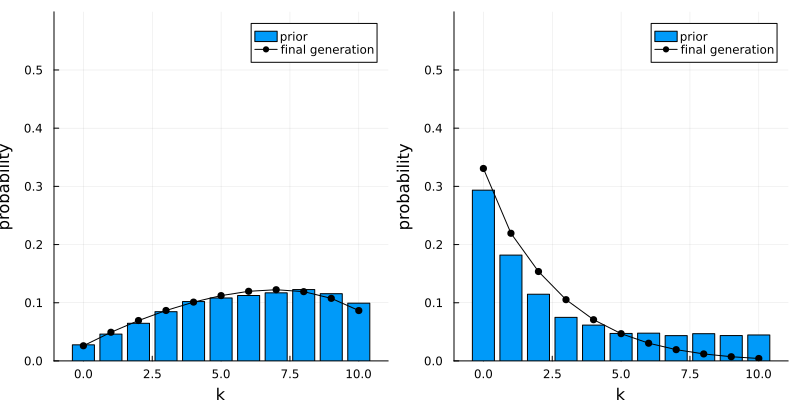

In [127]:
plot(
    iterated_final_plot(k_matrix1, parameters1),
    iterated_final_plot(k_matrix2, parameters2),
    size = (800, 400),
)

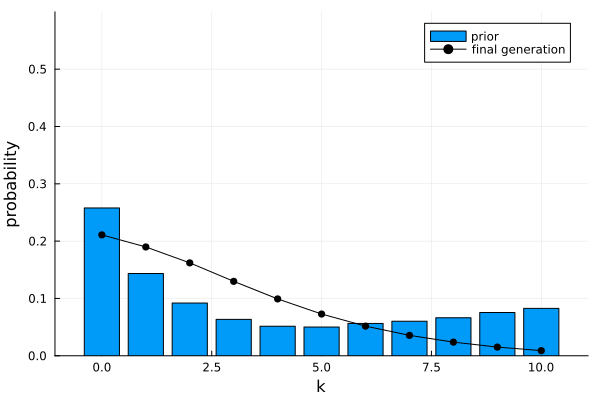

In [128]:
iterated_final_plot(k_matrix3, parameters3)

In [129]:
_, k_matrix1, parameters1 = mixed_iterated_learning(α₁ = 2.0, β₁ = 1.0, sampling = false)
_, k_matrix2, parameters2 = mixed_iterated_learning(α₁ = 1.0, β₁ = 10.0, sampling = false)
_, k_matrix3, parameters3 = mixed_iterated_learning(
    α₁ = 1.0,
    β₁ = 1.0,
    α₂ = 1.0,
    β₂ = 100.0,
    h = 0.95,
    sampling = false,
)

([4.7663, 4.5383, 4.3422, 4.144, 3.9721, 3.81, 3.6599, 3.486, 3.3302, 3.1794, 3.0382, 2.8976, 2.7667, 2.6463, 2.5316, 2.444, 2.3282, 2.2198, 2.1056, 2.0207], [0.03711734993965954 0.047646588234611056 … 0.03236996913045601 0.00809249225118003; 0.07168464814147184 0.07501847243308994 … 0.04849545635118128 0.02021561398726689; … ; 0.4219829890425543 0.18527162592935675 … 0.04676018718318696 0.09226600045072085; 0.4290278142741615 0.1876402250032354 … 0.0449220358842554 0.09006699653031382], Dict{Symbol, Real}(:sampling => false, :trials => 10000, :n => 10, :k => 5, :α₂ => 1.0, :β₁ => 1.0, :β₂ => 100.0, :h => 0.95, :generations => 20, :α₁ => 1.0…))

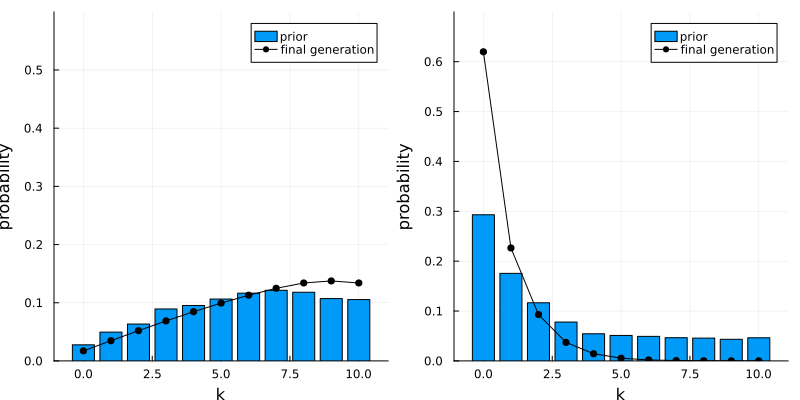

In [132]:
plot(
    iterated_final_plot(k_matrix1, parameters1),
    iterated_final_plot(k_matrix2, parameters2, 0.7),
    size = (800, 400),
)

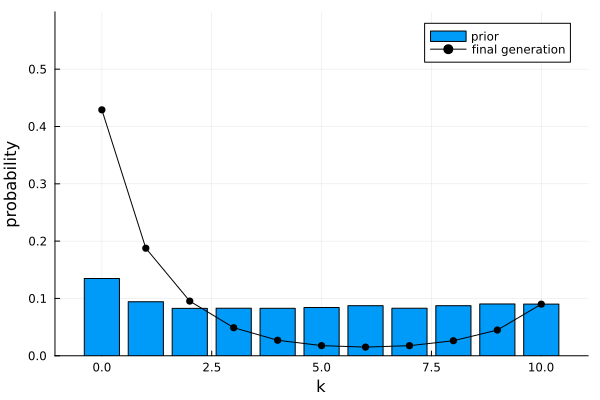

In [133]:
iterated_final_plot(k_matrix3, parameters3)